# Figure 10

[Skip code and jump to the figure](#Show-the-figure)

----------------------------------

In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
# Scientific and datavis stack
import iris
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from cmcrameri import cm
from matplotlib.offsetbox import AnchoredText

In [3]:
# My packages
from aeolus.calc import spatial, time_mean, water_path
from aeolus.const import add_planet_conf_to_cubes, init_const
from aeolus.core import AtmoSim
from aeolus.io import load_data
from aeolus.model import um
from aeolus.plot import subplot_label_generator
from pouch.clim_diag import calc_derived_cubes
from pouch.plot import KW_MAIN_TTL, KW_SBPLT_LABEL, XLOCS, YLOCS, figsave, use_style

In [4]:
# Local modules
import mypaths
from commons import GLM_SUITE_ID, SIM_LABELS

Apply custom matplotlib style sheet.

In [5]:
use_style()

## Load model data from the two key experiments

Define paths to input data and results.

In [6]:
img_prefix = f"{GLM_SUITE_ID}_mean"
inp_dir = mypaths.sadir / f"{GLM_SUITE_ID}_mean"
# time_prof = "mean_days6000_9950"
plotdir = mypaths.plotdir / img_prefix

Load processed data.

In [7]:
runs = {}
for sim_label, sim_prop in SIM_LABELS.items():
    planet = sim_prop["planet"]
    const = init_const(planet, directory=mypaths.constdir)
    if sim_label == "base":
        time_prof = "mean_days6000_9950"
    elif sim_label == "sens-noradcld":
        time_prof = "mean_days2000_2200"
    else:
        time_prof = "mean_days2000_2950"
    cl = load_data(
        files=inp_dir / f"{GLM_SUITE_ID}_{sim_label}_{time_prof}.nc",
    )

    add_planet_conf_to_cubes(cl, const)
    # Use the cube list to initialise an AtmoSim object
    calc_derived_cubes(cl, const=const)
    runs[sim_label] = AtmoSim(
        cl,
        name=sim_label,
        planet=planet,
        const_dir=mypaths.constdir,
        timestep=cl[0].attributes["timestep"],
        model=um,
    )

## Process variables before plotting

Target height of 10 m to interpolate near-surface winds to.

In [8]:
lev_10m = (
    [
        (um.z, [10]),
    ],
    iris.analysis.Linear(),
)

Store final results in a separate dictionary.

In [9]:
RESULTS = {}
for sim_label in SIM_LABELS.keys():
    RESULTS[sim_label] = {}

    the_run = runs[sim_label]
    RESULTS[sim_label]["lons"] = the_run.coord.x.points
    RESULTS[sim_label]["lats"] = the_run.coord.y.points

    RESULTS[sim_label]["t_sfc"] = time_mean(the_run.t_sfc)
    RESULTS[sim_label]["u_10m"] = iris.util.squeeze(
        time_mean(the_run.u).interpolate(*lev_10m)
    )
    RESULTS[sim_label]["v_10m"] = iris.util.squeeze(
        time_mean(the_run.v).interpolate(*lev_10m)
    )

    RESULTS[sim_label]["wvp"] = time_mean(
        water_path(the_run._cubes, kind="water_vapour")
    )
    RESULTS[sim_label]["cwp"] = time_mean(
        water_path(the_run._cubes, kind="cloud_water")
    )

## Create a figure

Define plotting style for the variables.

In [10]:
KW_WVP = dict(norm=mpl.colors.LogNorm(vmin=1e-1, vmax=1e1), cmap=cm.devon)
KW_CWP = dict(norm=mpl.colors.LogNorm(vmin=1e-3, vmax=1e0), cmap=cm.oslo)
KW_TSFC = dict(levels=np.arange(180, 291, 10), extend="both", cmap=cm.batlow)

KW_QUIVERKEY = dict(
    labelpos="N",
    labelsep=0.05,
    coordinates="axes",
    color="#444444",
    fontproperties=dict(size="xx-small"),
)

KW_QUIVER_EDDY = dict(
    scale_units="inches",
    scale=50,
    facecolors=("#444444"),
    edgecolors=("#EEEEEE"),
    linewidths=0.15,
    width=0.004,
    headaxislength=4,
)

# KW_CBAR = dict(fraction=0.0125, aspect=15, pad=0.025)
KW_CBAR = dict(pad=0.01)
KW_CBAR_TTL = dict(size="medium")

xstride = 8
ystride = 6
xsl = slice(None, None, xstride)
ysl = slice(None, None, ystride)

Assemble the figure.

In [11]:
imgname = f"{img_prefix}__{'_'.join(SIM_LABELS.keys())}__t_sfc_10m_winds_wvp_cwp"

add_min_max = True

ncols = 2
nrows = 3

fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(16, 12),
    gridspec_kw=dict(hspace=0.3, wspace=0.15),
)
# axd = fig.subplot_mosaic([[]])
iletters = subplot_label_generator()
for ax in axs.flat:
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
for ax in axs[:, :].flat:
    ax.set_ylim(-90, 90)
    ax.set_yticks(YLOCS)
    ax.set_xlim(-180, 180)
    ax.set_xticks(XLOCS)
    # if ax.get_subplotspec().is_first_col():
    ax.set_ylabel("Latitude [$\degree$]", fontsize="small")
    # if ax.get_subplotspec().is_last_row():
    ax.set_xlabel("Longitude [$\degree$]", fontsize="small")

for (sim_label, sim_prop), axcol in zip(SIM_LABELS.items(), axs.T):
    axcol[0].set_title(sim_prop["title"], **KW_MAIN_TTL)

    ax = axcol[0]
    _p0 = ax.contourf(
        RESULTS[sim_label]["lons"],
        RESULTS[sim_label]["lats"],
        RESULTS[sim_label]["t_sfc"].data,
        **KW_TSFC,
    )
    _q = ax.quiver(
        RESULTS[sim_label]["lons"][xsl],
        RESULTS[sim_label]["lats"][ysl],
        RESULTS[sim_label]["u_10m"].data[ysl, xsl],
        RESULTS[sim_label]["v_10m"].data[ysl, xsl],
        **KW_QUIVER_EDDY,
    )
    qk_ref_wspd = 10
    ax.quiverkey(
        _q,
        *(0.95, 1.025),
        qk_ref_wspd,
        rf"${qk_ref_wspd}$" + r" $m$ $s^{-1}$",
        **KW_QUIVERKEY,
    )
    if add_min_max:
        fmt = "3.0f"
        s = ["Surface\ntemperature"]
        for aggr in ["min", "mean", "max"]:
            s.append(
                f'{aggr.capitalize()}: {round(float(spatial(RESULTS[sim_label]["t_sfc"], aggr).data)):>{fmt}}'
            )
        at = AnchoredText(
            "\n".join(s),
            prop=dict(color="k", size="x-small"),
            frameon=True,
            loc="lower right",
        )
        at.patch.set_facecolor(mpl.colors.to_rgba("w", alpha=0.75))
        ax.add_artist(at)

    ax = axcol[1]
    _p1 = ax.pcolormesh(
        RESULTS[sim_label]["lons"],
        RESULTS[sim_label]["lats"],
        RESULTS[sim_label]["wvp"].data,
        **KW_WVP,
    )
    if add_min_max:
        fmt = "3.1e"
        s = ["WVP"]
        for aggr in ["min", "mean", "max"]:
            s.append(
                f'{aggr.capitalize()}: {float(spatial(RESULTS[sim_label]["wvp"], aggr).data):>{fmt}}'
            )
        at = AnchoredText(
            "\n".join(s),
            prop=dict(color="k", size="x-small"),
            frameon=True,
            loc="lower right",
        )
        at.patch.set_facecolor(mpl.colors.to_rgba("w", alpha=0.75))
        ax.add_artist(at)

    ax = axcol[2]
    _p2 = ax.pcolormesh(
        RESULTS[sim_label]["lons"],
        RESULTS[sim_label]["lats"],
        RESULTS[sim_label]["cwp"].data,
        **KW_CWP,
    )
    if add_min_max:
        fmt = "3.1e"
        s = ["CWP"]
        for aggr in ["min", "mean", "max"]:
            s.append(
                f'{aggr.capitalize()}: {float(spatial(RESULTS[sim_label]["cwp"], aggr).data):>{fmt}}'
            )
        at = AnchoredText(
            "\n".join(s),
            prop=dict(color="k", size="x-small"),
            frameon=True,
            loc="lower right",
        )
        at.patch.set_facecolor(mpl.colors.to_rgba("w", alpha=0.75))
        ax.add_artist(at)

_cbar0 = fig.colorbar(_p0, ax=axs[0, :], **KW_CBAR)
_cbar0.ax.set_ylabel("Surface temperature [$K$]", **KW_CBAR_TTL)
_cbar1 = fig.colorbar(_p1, ax=axs[1, :], **KW_CBAR)
_cbar1.ax.set_ylabel("Water vapour path [$kg$ $m^{-2}$]", **KW_CBAR_TTL)
_cbar2 = fig.colorbar(_p2, ax=axs[2, :], **KW_CBAR)
_cbar2.ax.set_ylabel("Cloud water path [$kg$ $m^{-2}$]", **KW_CBAR_TTL)

plt.close()

# Show the figure

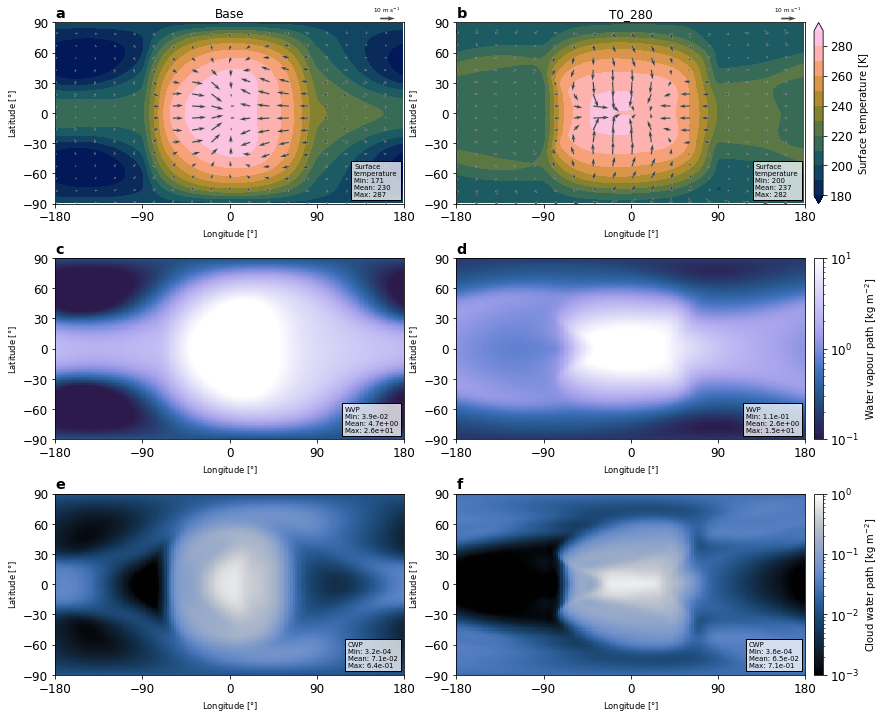

In [12]:
fig

* **Steady state thermodynamic conditions in the (left) _Base_ (SJ regime) and (right) _T0\_280_ (DJ regime) simulations.**
* **The panels show (a, b) surface temperature (shading, $K$) with $10\,m$ wind vectors, (c, d) water vapor path (shading, $kg\,m^{-2}$), and (e, f) cloud water path (shading, $kg\,m^{-2}$).**

In [13]:
figsave(fig, plotdir / imgname)

Saved to ../plots/ch111_mean/ch111_mean__base_sens-t280k__t_sfc_10m_winds_wvp_cwp.png
